# inverse design of a grating coupler with a vertical angle

This code is designed for a vertical output angle. 

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal
import os
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
mp.verbosity(0)


1

In [2]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 10
output_wvg_length = 5
# design_region
design_region_x = 15
design_region_y = 0.2
# period = 0.707  # period of grating coupler
# duty_cycle = 0.53  # duty cycle of grating coupler
# number_period = 20  # number of period of grating coupler
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

####################### geometry ##########################

####################### design region ##########################
minimum_length = 0.05  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

design_region_resolution_x = int(resolution)
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)
####################### design region ##########################

####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)
####################### Sources ##########################

####################### filter and projection (not use) ##########################

# def mapping(x, eta, beta):

#     # filter
#     filtered_field = mpa.conic_filter(
#         x,
#         filter_radius,
#         design_region_x,
#         design_region_y,
#         design_region_resolution,
#     )

#     # projection
#     projected_field = mpa.tanh_projection(filtered_field, beta, eta)

#     projected_field = (
#         npa.flipud(projected_field) + projected_field
#     ) / 2  # left-right symmetry

#     # interpolate to actual materials
#     return projected_field.flatten()


####################### filter and projection ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)


**Define Opt**

In [3]:
1####################### monitor ##########################
# near_field_region
far_x = [mp.Vector3(0, 1e6, 0)]
NearRegion = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=+1,
    )
]

FarFields = mpa.Near2FarFields(sim, NearRegion, far_x)
ob_list = [FarFields]


def J1(FF):
    return npa.mean(npa.abs(FF[0, 0, 2]) ** 2)


####################### monitor ##########################

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J1],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    decay_by=1e-5,
)


**Confirm the optimization configuration.**

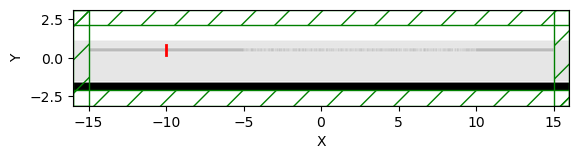

In [4]:
# define the initial design and confirm the optimization problem
number_para = Nx * Ny
init_para = npa.random.random(number_para)
opt.update_design([init_para])
opt.plot2D(False)


**Define Nlopt**

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


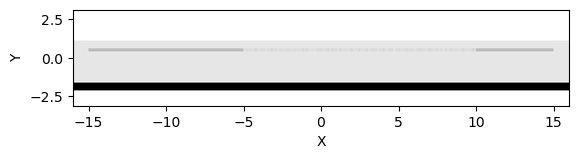

Objective function: 2.6615988142645617e-08
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


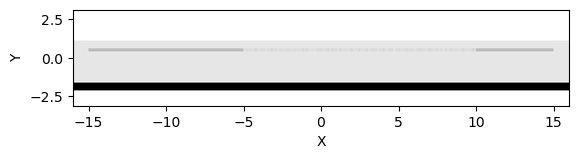

Objective function: 2.6615994172587175e-08
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


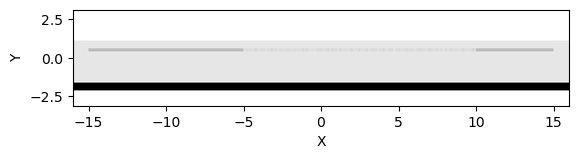

Objective function: 2.6616054472044975e-08
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


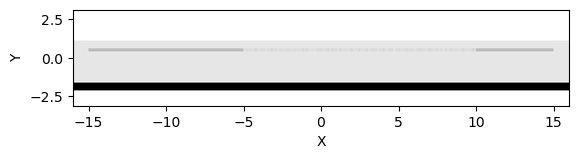

Objective function: 2.6616922792910855e-08
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


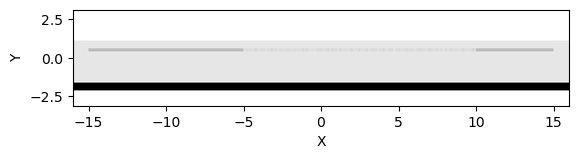

Objective function: 2.6629428435992793e-08
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


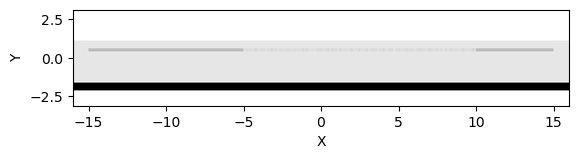

Objective function: 2.680989183762577e-08
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


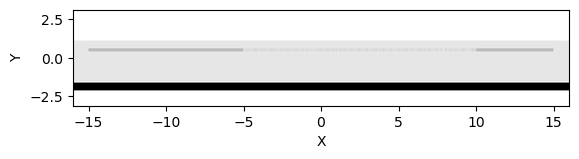

Objective function: 2.948887166952775e-08
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


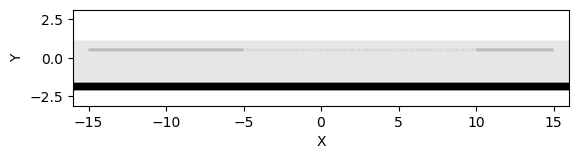

Objective function: 3.3810094842072345e-08
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


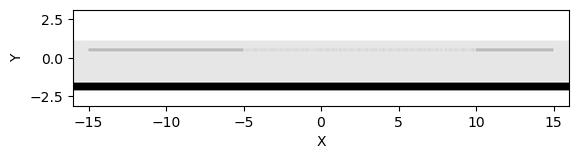

Objective function: 4.1142427435599464e-08
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


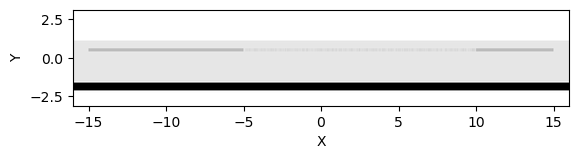

Objective function: 5.445000296273785e-08
Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


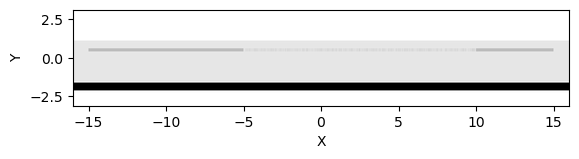

Objective function: 8.104753872083844e-08
Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


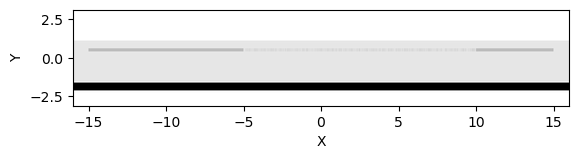

Objective function: 1.4220405320707195e-07
Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


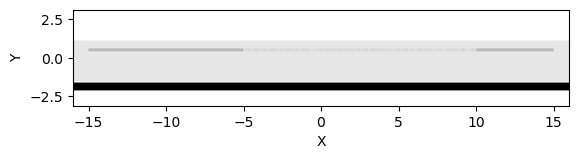

Objective function: 3.1191194724993365e-07
Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


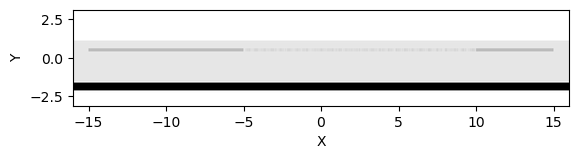

Objective function: 9.256200600298608e-07
Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


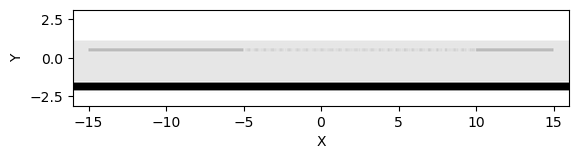

Objective function: 4.052405633163501e-06
Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


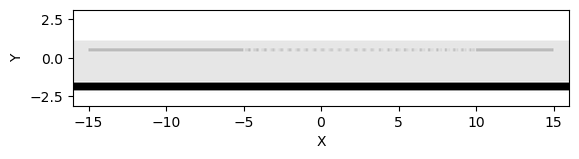

Objective function: 5.7186824131968086e-06
Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


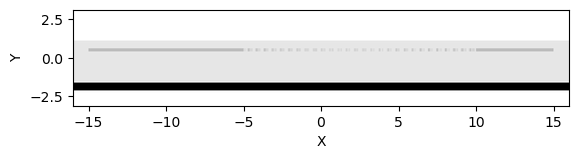

Objective function: 3.861779397762134e-06
Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


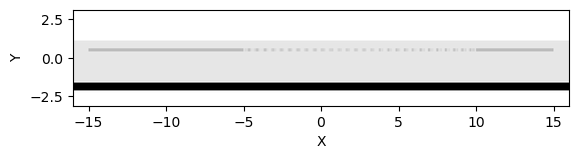

Objective function: 1.0032720191197336e-05
Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


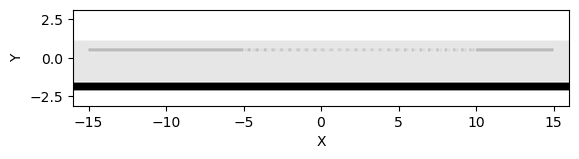

Objective function: 9.044528627682704e-06
Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


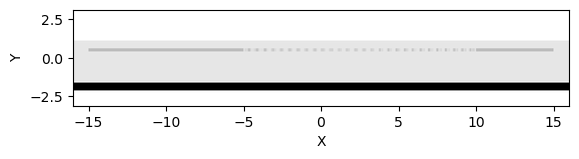

Objective function: 1.1212207581225648e-05
Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


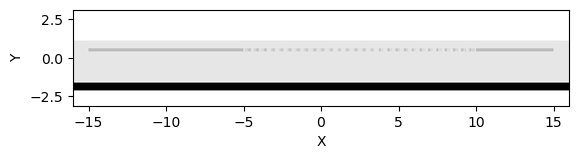

Objective function: 5.596229036530561e-06
Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


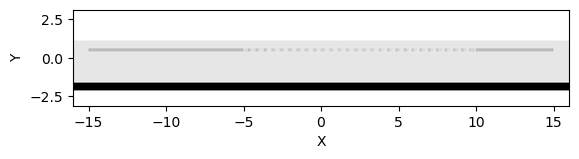

Objective function: 1.1493268011808832e-05
Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


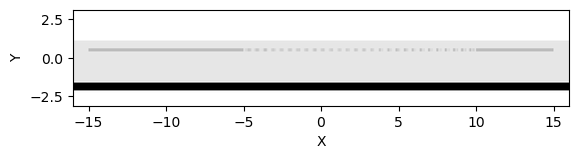

Objective function: 1.1098037562933955e-05
Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


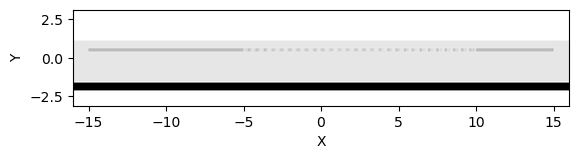

Objective function: 1.1689460540236185e-05
Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


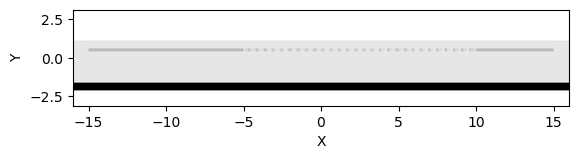

Objective function: 9.320843798164557e-06
Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


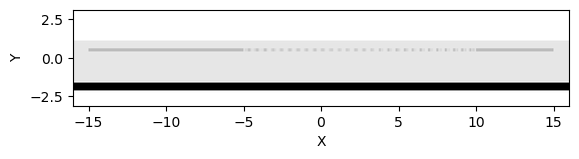

Objective function: 1.1884238917182503e-05
Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


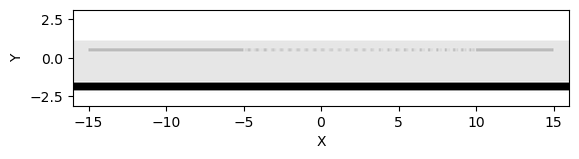

Objective function: 1.1920692472623831e-05
Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


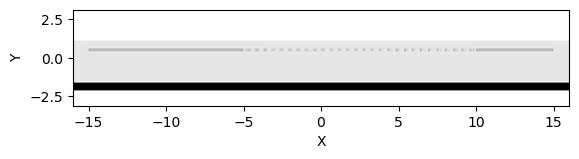

Objective function: 1.2205573796085643e-05
Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


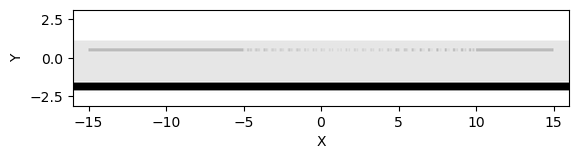

Objective function: 3.19075260463305e-06
Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


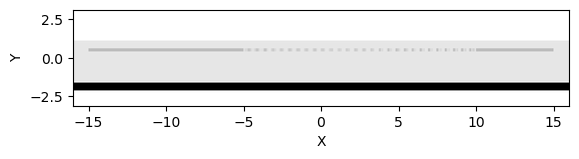

Objective function: 1.1766727561226342e-05
Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


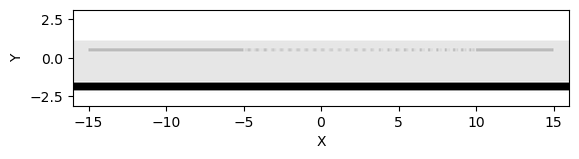

Objective function: 1.2262340929557967e-05
Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


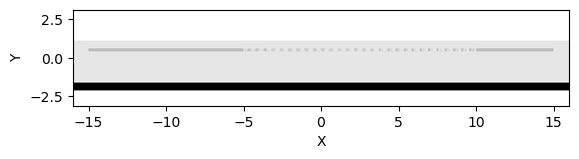

Objective function: 1.2310068712196845e-05
Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...


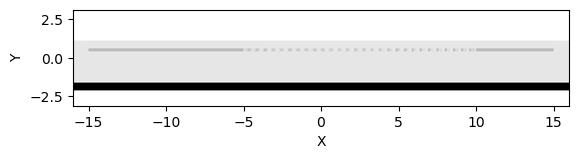

Objective function: 1.250601205712065e-05
Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...


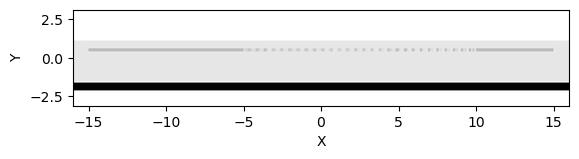

Objective function: 1.1410615233441413e-05
Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...


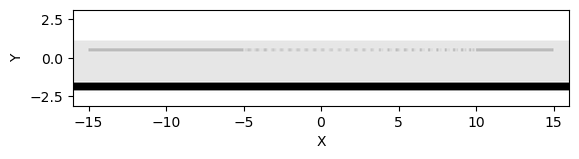

Objective function: 1.2606848716022377e-05
Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...


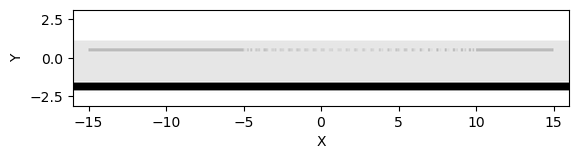

Objective function: 3.894306330837059e-06
Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...


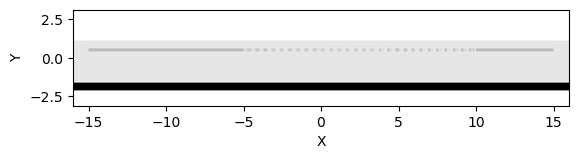

Objective function: 1.2484616278947187e-05
Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...


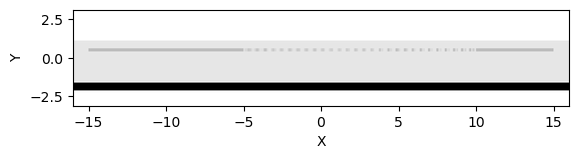

Objective function: 1.2695446574455935e-05
Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...


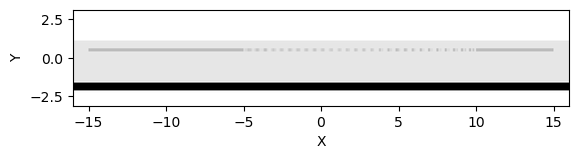

Objective function: 1.2941008159216755e-05
Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...


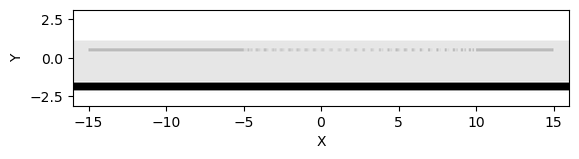

Objective function: 9.5824089075547e-06
Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...


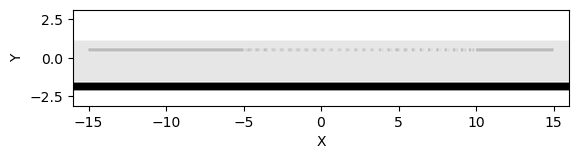

Objective function: 1.2983807657376726e-05
Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


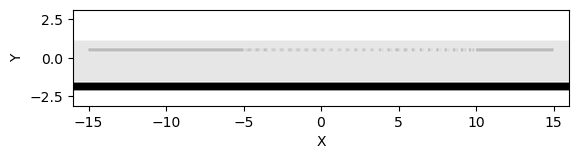

Objective function: 1.3042628826642204e-05
Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


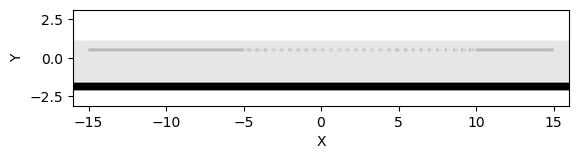

Objective function: 1.3106790574050643e-05
Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...


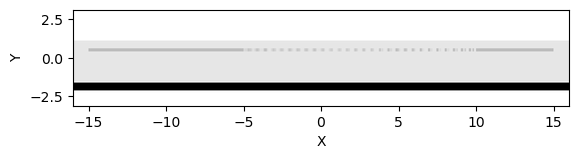

Objective function: 1.3210197659177302e-05
Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...


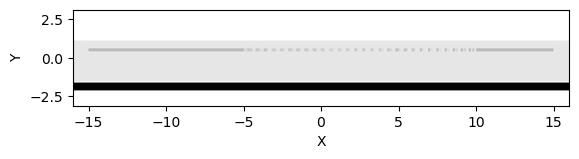

Objective function: 1.17255226187131e-05
Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...


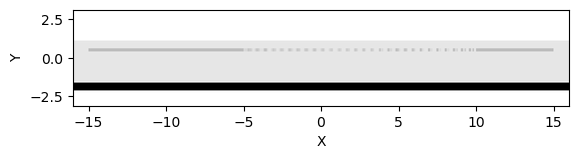

Objective function: 1.3214733935473549e-05
Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...


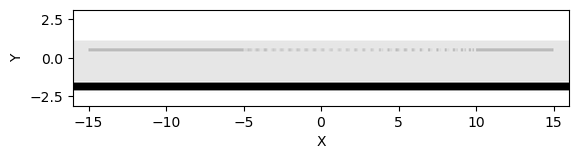

Objective function: 1.3312732423304812e-05
Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...


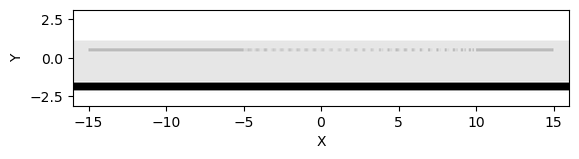

Objective function: 1.2529804667450615e-05
Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...


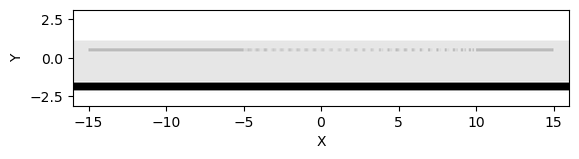

Objective function: 1.33301282872391e-05
Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...


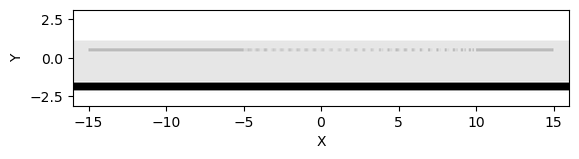

Objective function: 1.3400793411700333e-05
Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...


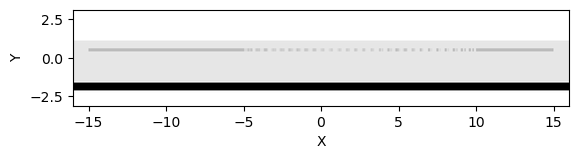

Objective function: 1.0122193919284424e-05
Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...


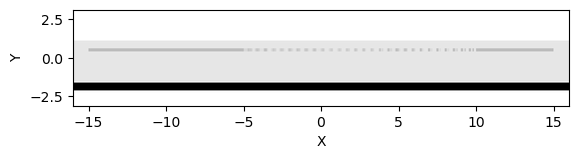

Objective function: 1.3360272665458492e-05
Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...


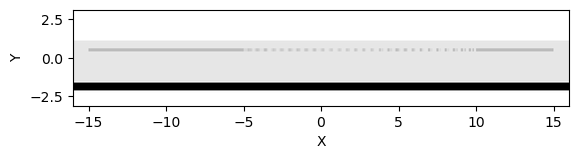

Objective function: 1.3429917095784745e-05
Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...


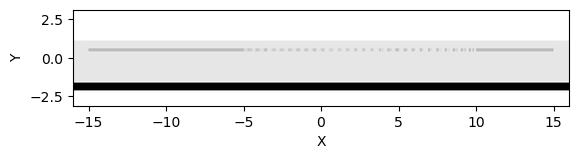

Objective function: 1.3515111724375403e-05
Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...


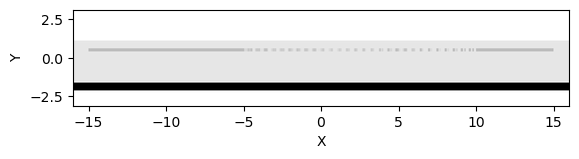

Objective function: 1.1727481074069002e-05
Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...


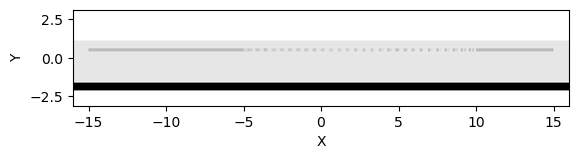

Objective function: 1.3536236684088729e-05
Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...


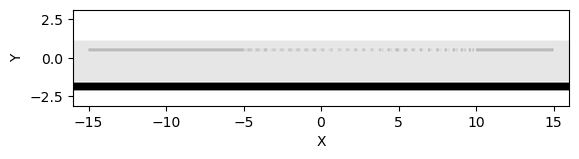

Objective function: 1.3298648330329429e-05
Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...


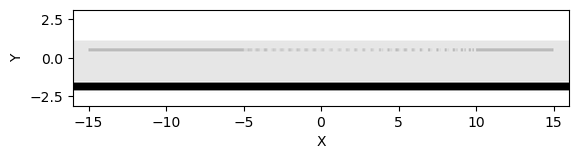

Objective function: 1.353845636044385e-05
Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...


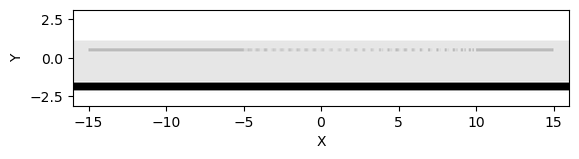

Objective function: 1.3550808845455544e-05
Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...


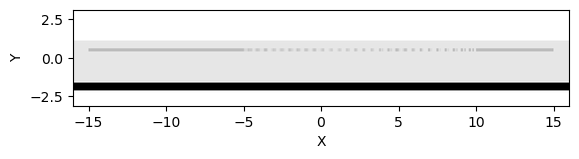

Objective function: 1.3619994751301682e-05
Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...


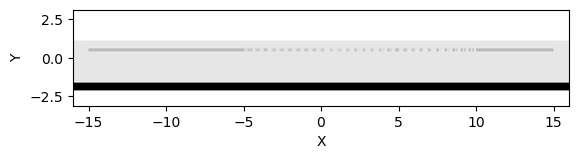

Objective function: 1.3679197338371708e-05
Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...


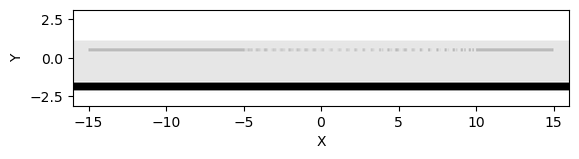

Objective function: 1.2290299119463916e-05
Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


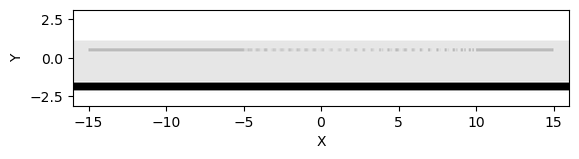

Objective function: 1.37160718571189e-05
Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


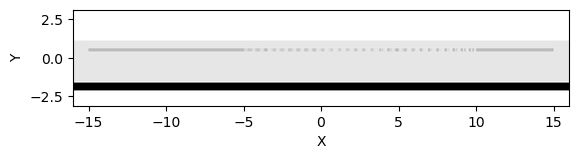

Objective function: 1.2325188171963508e-05
Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...


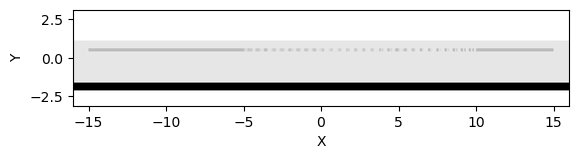

Objective function: 1.3724036523161095e-05
Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...


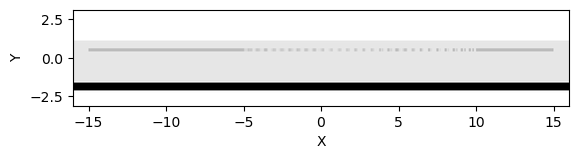

Objective function: 1.3731816669371759e-05
Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...


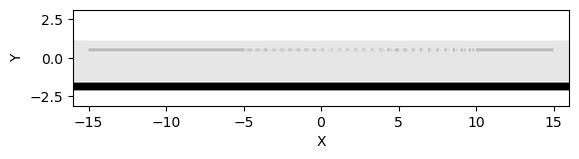

Objective function: 1.3778054636828393e-05
Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...


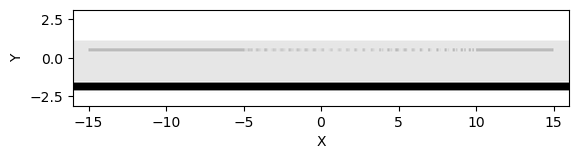

Objective function: 1.2021060364665688e-05
Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...


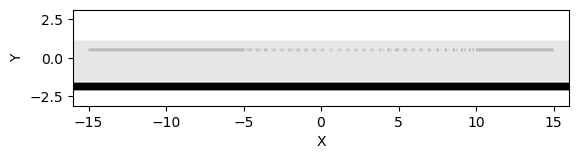

Objective function: 1.3742912645703226e-05
Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...


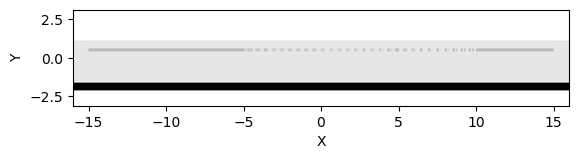

Objective function: 1.3784045456984821e-05
Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...


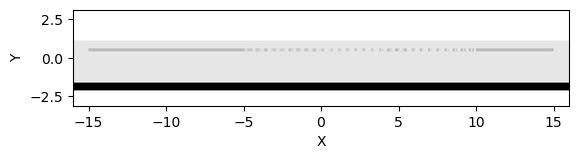

Objective function: 1.3774587964176878e-05
Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...


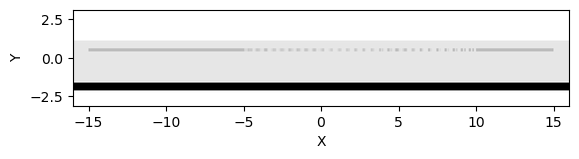

Objective function: 1.3791680457760182e-05
Current iteration: 73
Starting forward run...
Starting adjoint run...
Calculating gradient...


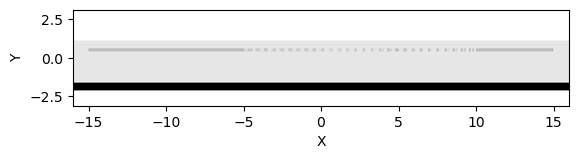

Objective function: 1.3802747998791024e-05
Current iteration: 74
Starting forward run...
Starting adjoint run...
Calculating gradient...


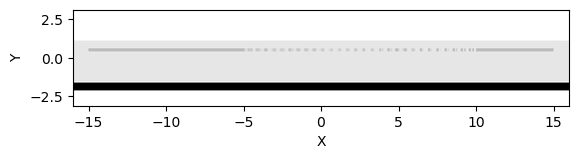

Objective function: 1.3344583672576027e-05
Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...


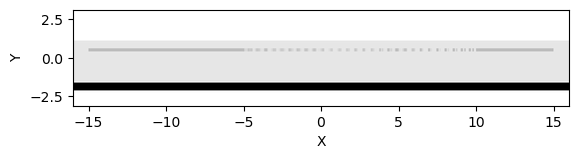

Objective function: 1.3825838731751044e-05
Current iteration: 76
Starting forward run...
Starting adjoint run...
Calculating gradient...


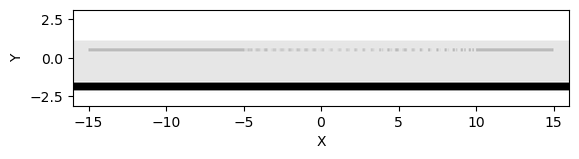

Objective function: 1.3692681746471114e-05
Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...


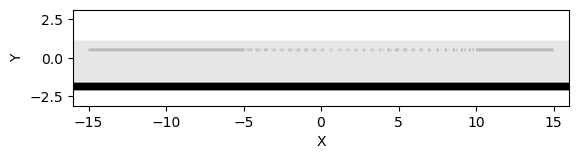

Objective function: 1.3837114796834566e-05
Current iteration: 78
Starting forward run...
Starting adjoint run...
Calculating gradient...


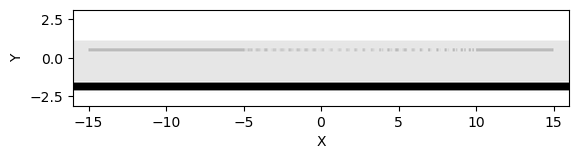

Objective function: 1.3722499849240901e-05
Current iteration: 79
Starting forward run...
Starting adjoint run...
Calculating gradient...


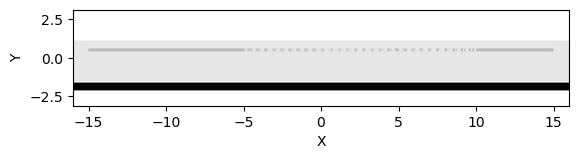

Objective function: 1.3844150504989148e-05
Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...


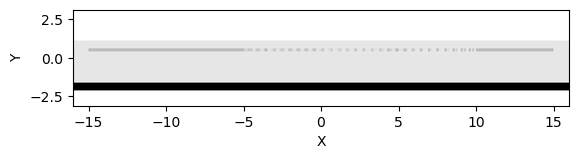

Objective function: 1.2867508678471992e-05
Current iteration: 81
Starting forward run...
Starting adjoint run...
Calculating gradient...


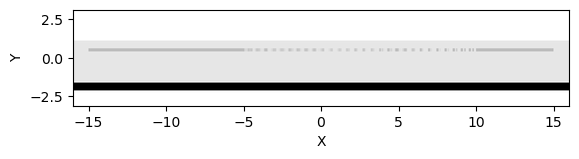

Objective function: 1.3846609653599752e-05
Current iteration: 82
Starting forward run...
Starting adjoint run...
Calculating gradient...


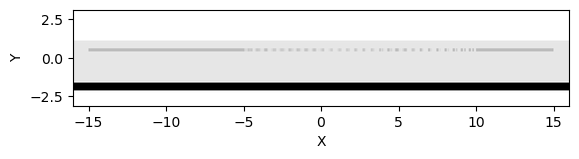

Objective function: 1.3479283821981021e-05
Current iteration: 83
Starting forward run...
Starting adjoint run...
Calculating gradient...


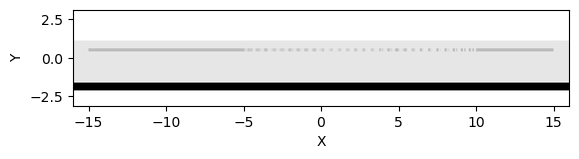

Objective function: 1.384749666497276e-05
Current iteration: 84
Starting forward run...
Starting adjoint run...
Calculating gradient...


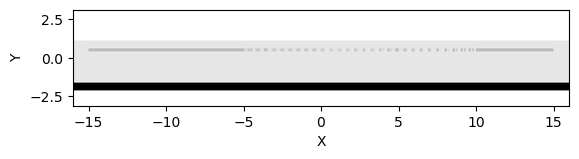

Objective function: 1.3854134827764679e-05
Current iteration: 85
Starting forward run...
Starting adjoint run...
Calculating gradient...


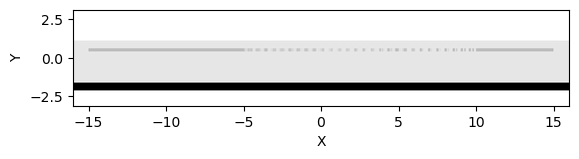

Objective function: 1.3628376343013897e-05
Current iteration: 86
Starting forward run...
Starting adjoint run...
Calculating gradient...


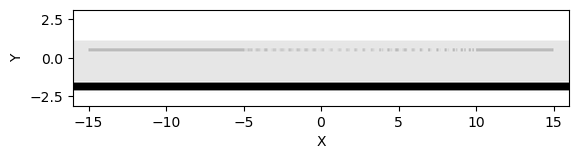

Objective function: 1.3856620468164563e-05
Current iteration: 87
Starting forward run...
Starting adjoint run...
Calculating gradient...


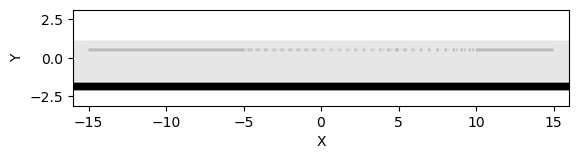

Objective function: 1.3874301220675408e-05
Current iteration: 88
Starting forward run...
Starting adjoint run...
Calculating gradient...


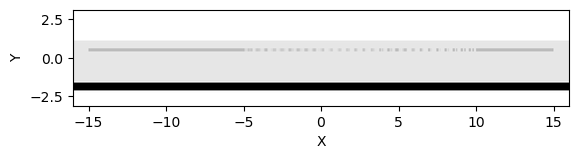

Objective function: 1.3774249485408006e-05
Current iteration: 89
Starting forward run...
Starting adjoint run...
Calculating gradient...


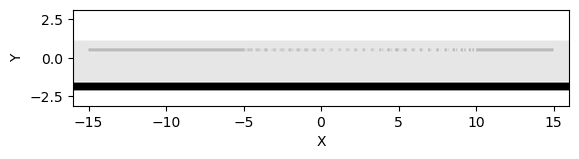

Objective function: 1.3882480921074662e-05
Current iteration: 90
Starting forward run...
Starting adjoint run...
Calculating gradient...


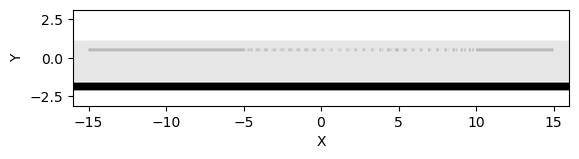

Objective function: 1.3239556128857949e-05
Current iteration: 91
Starting forward run...
Starting adjoint run...
Calculating gradient...


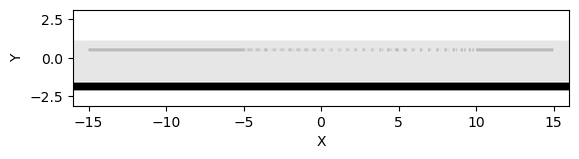

Objective function: 1.3881287100826882e-05
Current iteration: 92
Starting forward run...
Starting adjoint run...
Calculating gradient...


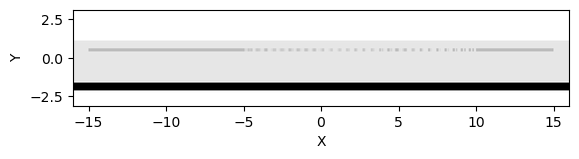

Objective function: 1.3891805280745064e-05
Current iteration: 93
Starting forward run...
Starting adjoint run...
Calculating gradient...


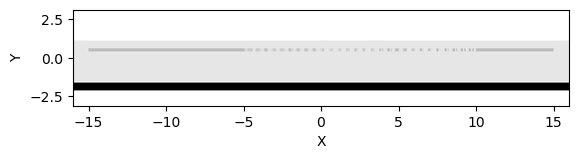

Objective function: 1.3897291844266114e-05
Current iteration: 94
Starting forward run...
Starting adjoint run...
Calculating gradient...


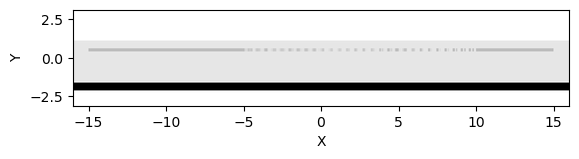

Objective function: 1.3845597234458922e-05
Current iteration: 95
Starting forward run...
Starting adjoint run...
Calculating gradient...


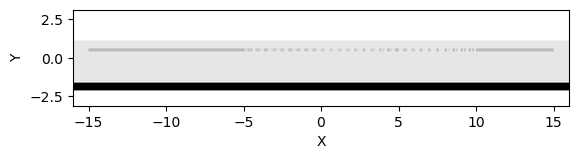

Objective function: 1.3897426845978872e-05
Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...


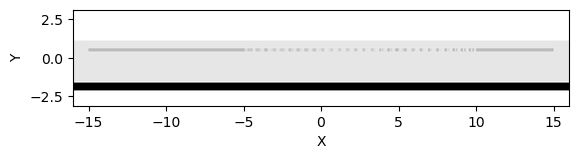

Objective function: 1.3898246643877527e-05
Current iteration: 97
Starting forward run...
Starting adjoint run...
Calculating gradient...


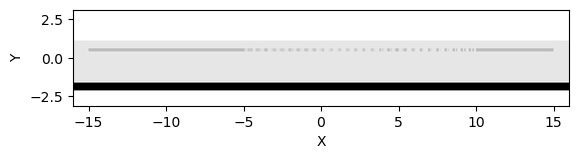

Objective function: 1.3767821572610821e-05
Current iteration: 98
Starting forward run...
Starting adjoint run...
Calculating gradient...


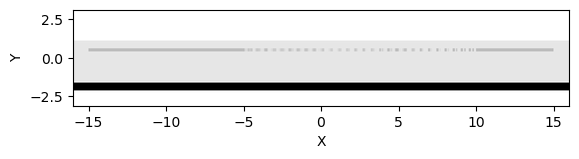

Objective function: 1.2839678456049547e-05
Current iteration: 99
Starting forward run...
Starting adjoint run...
Calculating gradient...


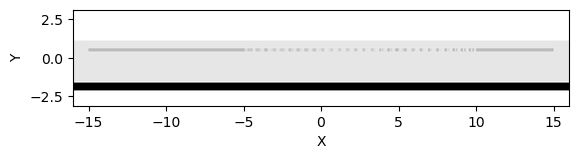

Objective function: 1.3898341811120029e-05
Current iteration: 100
Starting forward run...
Starting adjoint run...
Calculating gradient...


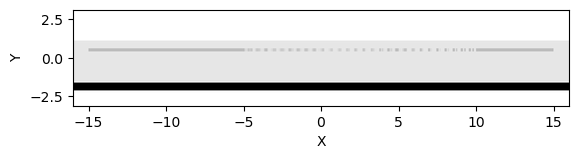

Objective function: 1.2840040839976822e-05


In [5]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([v])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = np.squeeze(dJ_du)

    evaluation_history.append(np.real(f0))

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    # circ = Circle((2, 2), minimum_length / 2)
    # ax.add_patch(circ)
    # ax.axis("off")
    plt.show()
    print("Objective function: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.random.random((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))


# cur_beta = 4
# beta_scale = 2
# num_betas = 6
update_factor = 100
ftol = 1e-5

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(lb)
solver.set_upper_bounds(ub)
solver.set_max_objective(lambda a, g: f(a, g))
solver.set_maxeval(update_factor)
# solver.set_ftol_rel(ftol)
x[:] = solver.optimize(x)

/tmp/ipykernel_11515/110120642.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


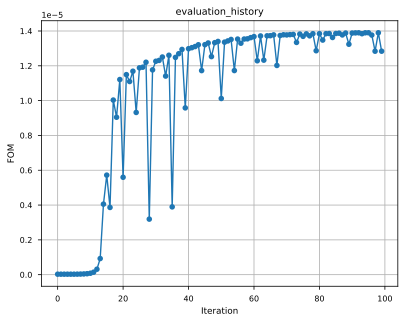

In [6]:
%config InlineBackend.figure_format = 'svg'

plt.figure()
plt.style.use("seaborn-paper")
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.title('evaluation_history')
plt.show()


In [7]:
print(evaluation_history)


[2.6615988142645617e-08, 2.6615994172587175e-08, 2.6616054472044975e-08, 2.6616922792910855e-08, 2.6629428435992793e-08, 2.680989183762577e-08, 2.948887166952775e-08, 3.3810094842072345e-08, 4.1142427435599464e-08, 5.445000296273785e-08, 8.104753872083844e-08, 1.4220405320707195e-07, 3.1191194724993365e-07, 9.256200600298608e-07, 4.052405633163501e-06, 5.7186824131968086e-06, 3.861779397762134e-06, 1.0032720191197336e-05, 9.044528627682704e-06, 1.1212207581225648e-05, 5.596229036530561e-06, 1.1493268011808832e-05, 1.1098037562933955e-05, 1.1689460540236185e-05, 9.320843798164557e-06, 1.1884238917182503e-05, 1.1920692472623831e-05, 1.2205573796085643e-05, 3.19075260463305e-06, 1.1766727561226342e-05, 1.2262340929557967e-05, 1.2310068712196845e-05, 1.250601205712065e-05, 1.1410615233441413e-05, 1.2606848716022377e-05, 3.894306330837059e-06, 1.2484616278947187e-05, 1.2695446574455935e-05, 1.2941008159216755e-05, 9.5824089075547e-06, 1.2983807657376726e-05, 1.3042628826642204e-05, 1.310679

In [8]:
f0, _ = opt([x])

Starting forward run...
Starting adjoint run...
Calculating gradient...


In [9]:
print(f0)

1.3898341811120029e-05


FloatProgress(value=0.0, description='0% done ', max=200.0)

<Axes: xlabel='X', ylabel='Y'>

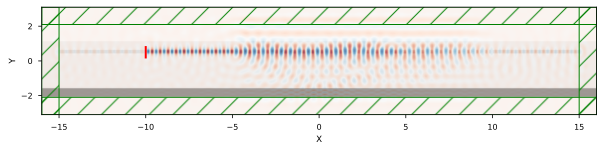

In [10]:
source_cw = [
    mp.EigenModeSource(
        mp.ContinuousSource(frequency=fcen),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]

opt.sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=source_cw,
    geometry=geometry,
)

opt.sim.run(until=200)
plt.figure(figsize=(10, 20))
opt.sim.plot2D(fields=mp.Ez)


**Verify the optimization result**

In [11]:
sim_final = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=source_cw,
    geometry=geometry,
)
near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)
n2f_field = sim.add_near2far(
    fcen,
    0,
    1,
    near_region,
)

In [12]:
# import math

# ff_distance = 1e5  # far-field distance from near-field monitor
# ff_angle = 80  # far-field cone angle
# ff_npts = 500  # number of far-field points
# # single-side far-field length
# ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# # [-ff_length, ff_length]
# ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# # resolution
# ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

# ff = sim.get_farfields(
#     n2f_field,
#     ff_res,
#     center=mp.Vector3(0, ff_distance),
#     size=mp.Vector3(x=2 * ff_length),
# )
# # [-angle, angle]
# angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
# rel_enh = np.abs(ff["Ez"]) ** 2

# figure, ax = plt.subplots()
# plt.plot(angles, rel_enh, "-")
# plt.title(r"$ Ez $ far field")
# ax.set_xlabel("angle")
# ax.set_ylabel(r"$ E_z $")

# index = np.argmax(rel_enh)
# print(f"Output_angle of grating coupler: {angles[index]} degree")